<a href="https://colab.research.google.com/github/jinaypanchal/Deep-Learning-Architecture-and-Hardware-Acceleration/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'torch.utils.data.dataloader.DataLoader'>
Delta Rule Losses: [700.0, 119.99999228864908, -269.9999892152846, 20.00000434720664]
Batch Delta Rule Losses: [410.4627380371094, 138.33218383789062, 45.849019368489586, 14.249013264973957, 3.316925048828125, -0.57159423828125, -2.037679036458334, -2.653391520182292, -2.956858317057292, -3.135050455729167]
Testing MSE: 1938.6666650870095


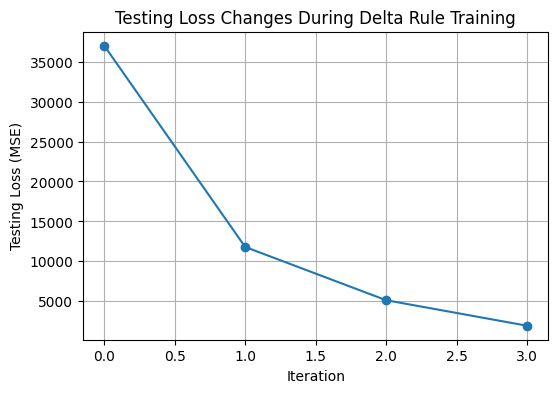

Final Testing MSE: 1938.6666650870095


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


class train_data(Dataset):
    def __init__(self, inputs, targets, learning_rates):
        self.inputs = inputs
        self.targets = targets
        self.learning_rates = learning_rates

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.learning_rates[idx]

class test_data(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def custom_linear_model(x, weights):
    # Calculate the linear prediction (no bias term)
    return torch.sum(x * weights)

def delta_rule(train_loader, test_loader):
    weights = torch.tensor([50.0, 50.0, 50.0], requires_grad=True)
    losses = []
    testing_losses = []
    print(train_loader)
    print(test_loader)
    print(type(train_loader))

    for i, (inputs, target, learning_rate) in enumerate(train_loader):
        inputs = torch.tensor(inputs, dtype=torch.float32, requires_grad=False)
        prediction = custom_linear_model(inputs, weights)
        loss = target - prediction
        losses.append(loss.item())

        # Update weights
        learning_rate = train_loader.dataset.learning_rates[i]
        weights = weights + learning_rate * inputs * loss
        test_loss = calculate_mse(test_loader, weights)
        testing_losses.append(test_loss)

    return losses, weights, testing_losses

def batch_delta_rule(train_loader, inputs):
    weights = torch.tensor([50.0, 50.0, 50.0], requires_grad=True)
    losses = []

    for epoch in range(10):
        epoch_loss = 0.0
        for batch_start in range(0, len(train_loader), batch_size):
            batch_end = min(batch_start + batch_size, len(train_loader))
            batch_losses = []

            for i in range(batch_start, batch_end):
                inputs_batch, target, _ = train_loader.dataset[i]
                inputs_batch = torch.tensor(inputs_batch, dtype=torch.float32)
                prediction = custom_linear_model(inputs_batch, weights)
                loss = target - prediction
                batch_losses.append(loss.item())

                # Update weights
                learning_rate = 1/100
                weights = weights + learning_rate * inputs_batch * loss

            # Calculate batch loss
            batch_loss = sum(batch_losses) / len(batch_losses)
            epoch_loss += batch_loss

        losses.append(epoch_loss)

    return losses, weights

def calculate_mse(test_loader, weights):
    mse = 0.0

    for inputs, target in test_loader:
        inputs = torch.tensor(inputs, dtype=torch.float32, requires_grad=False)
        prediction = torch.sum(inputs * weights)
        mse += (target - prediction) ** 2

    mse /= len(test_loader)
    return mse.item()

# Define inputs and targets for both train and test datasets
delta_train_inputs = [
    (5.0, 2.0, 4.0),
    (3.0, 3.0, 3.0),
    (0.0, 5.0, 1.0),
    (2.0, 1.0, 2.0),
]

delta_train_targets = [1250.0, 900.0, 350.0, 550.0]
delta_learning_rates = [1/70.0, 1/12.0, 1/27.0, 2/20.0]

delta_test_inputs = [
    (6.0, 1.0, 3.0),
    (2.0, 2.0, 1.0),
    (4.0, 5.0, 0.0),
]

delta_test_targets = [1250.0, 500.0, 850.0]

# Define inputs and targets for the batch delta rule
batch_delta_train_inputs = [
    (5.0, 2.0, 4.0),
    (3.0, 3.0, 3.0),
    (0.0, 5.0, 1.0),
    (2.0, 1.0, 2.0),
    (1.0, 0.0, 5.0),
    (4.0, 2.0, 1.0),
    (6.0, 1.0, 1.0),
    (2.0, 3.0, 4.0),
    (7.0, 3.0, 0.0),
    (4.0, 4.0, 2.0),
    (1.0, 5.0, 7.0),
    (5.0, 1.0, 3.0),
]

batch_delta_train_targets = [1250.0, 900.0, 350.0, 550.0, 650.0, 800.0, 1050.0, 850.0, 1200.0, 1000.0, 1100.0, 1100.0]

batch_delta_test_inputs = [
    (6.0, 1.0, 3.0),
    (2.0, 2.0, 1.0),
    (4.0, 5.0, 0.0),
]

batch_delta_test_targets = [1250.0, 500.0, 850.0]

# Create datasets and data loaders for both delta rule and batch delta rule
delta_train_dataset = train_data(delta_train_inputs, delta_train_targets, delta_learning_rates)
delta_test_dataset = test_data(delta_test_inputs, delta_test_targets)

batch_delta_train_dataset = train_data(batch_delta_train_inputs, batch_delta_train_targets, [1/100.0]*len(batch_delta_train_inputs))
batch_delta_test_dataset = test_data(batch_delta_test_inputs, batch_delta_test_targets)

delta_train_loader = DataLoader(delta_train_dataset, batch_size=1)
delta_test_loader = DataLoader(delta_test_dataset, batch_size=1)

batch_delta_train_loader = DataLoader(batch_delta_train_dataset, batch_size=3)
batch_delta_test_loader = DataLoader(batch_delta_test_dataset, batch_size=1)

num_epochs = 10
batch_size = 3

# delta_losses, delta_weights = delta_rule(delta_train_loader)
delta_losses, delta_weights, test_losses = delta_rule(delta_train_loader, delta_test_loader)
batch_delta_losses, batch_delta_weights = batch_delta_rule(batch_delta_train_loader, delta_train_inputs)
test_mse = calculate_mse(delta_test_loader, delta_weights)  # or batch_delta_weights

print("Delta Rule Losses:", delta_losses)
print("Batch Delta Rule Losses:", batch_delta_losses)
print("Testing MSE:", test_mse)

plt.figure(figsize=(6, 4))
plt.plot(range(len(test_losses)), test_losses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Testing Loss (MSE)')
plt.title('Testing Loss Changes During Delta Rule Training')
plt.grid(True)
plt.show()

# Print final testing MSE
final_test_mse = test_losses[-1]
print("Final Testing MSE:", final_test_mse)


